In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
#import cmocean as cm
import seawater as sw
import gsw
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(10)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.2:52397 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_mooring = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/random_location/'

In [6]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_T = xr.open_zarr(out_dir_zarr+'Theta_total_rechunk.zarr')
ds_S = xr.open_zarr(out_dir_zarr+'Salt_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_T,ds_S,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
 

In [7]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])
print(ds_surface)

<xarray.Dataset>
Dimensions:   (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat       (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon       (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    XC        (lat, lon) float32 ...
    YC        (lat, lon) float32 ...
    XG        (lat_g, lon_g) float32 ...
    YG        (lat_g, lon_g) float32 ...
    CS        (lat, lon) float32 ...
    SN        (lat, lon) float32 ...
    Depth     (lat, lon) float32 ...
    dxC       (lat, lon_g) float32 ...
    dyC       (lat_g, lon) float32 ...
    dxG       (lat_g, lon) float32 ...
    dyG       (lat, lon_g) float32 ...
    rA        (lat, lon) float32 ...
    rAz       (lat_g, lon_g) float32 ...
    rAw       (lat, lon_g) float32 ...
    rAs       (lat_g, lon) float32 ...
  * lat_g     (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...
  *

In [8]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center


## Buoyancy

In [12]:
# define buoyancy, density functions (all input salt, theta, depth)
def buoyancy(Salt,Theta,depth):
    sigma = density(Salt,Theta,depth)
    if np.nanmean(sigma)<500:
        sigma += 1000
    return g*(1-sigma/rho_0)

def density(Salt,Theta,depth):
    SA = gsw.SA_from_SP(Salt, depth, OSMOSIS_LON, OSMOSIS_LAT)
    CT = gsw.CT_from_pt(SA, Theta)
    return gsw.density.sigma0(SA, CT)

In [ ]:
OSMOSIS_LON = -16.1875
OSMOSIS_LAT = 48.6875

pd = density(ds.Theta,ds.Salt,ds.depth)
pd

In [ ]:
SA = gsw.SA_from_SP(ds.Salt,ds.depth, ds.lon, ds.lat)
SA

In [11]:
Sa = ds.Salt.isel(lat=1,lon=1)
Sa

<xarray.DataArray 'Salt' (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float32, chunksize=(9415, 1)>
Coordinates:
    lat      float64 47.42
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    lon      float64 -18.01
    XC       float32 ...
    YC       float32 ...
    CS       float32 ...
    SN       float32 ...
    Depth    float32 ...
    rA       float32 ...

In [13]:
SA = gsw.SA_from_SP(Sa,Sa.depth, -18.01, 47.42)
SA = SA.to_dataset()
SA

array([[35.76086621, 35.76051   , 35.76036517, ..., 35.50961393,
        35.43894607, 35.3981871 ],
       [35.75397498, 35.7536226 , 35.7534816 , ..., 35.52136968,
        35.44654689, 35.4016253 ],
       [35.74565031, 35.7453056 , 35.7451646 , ..., 35.51407935,
        35.44239576, 35.39983912],
       ...,
       [35.36040444, 35.46900477, 35.51162923, ..., 35.65640555,
        35.64503807, 35.62955033],
       [35.34094955, 35.47708414, 35.50811846, ..., 35.65300953,
        35.64225532, 35.62672542],
       [35.32169013, 35.48068307, 35.50497563, ..., 35.64984349,
        35.63938825, 35.62316457]])

In [16]:
SA = SA.to_series()
SA

AttributeError: 'numpy.ndarray' object has no attribute 'to_series'

# w'

In [25]:
w_mean = ds.W.mean(['lat','lon'])
u_mean = ds.U.mean(['lat','lon_g'])

In [26]:
w_prime = ds.W - w_mean
u_prime = ds.U - u_mean

In [27]:
w_prime

<xarray.DataArray 'W' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [29]:
u_prime_ij = gridx.interp(u_prime,'X')
u_prime_ij

<xarray.DataArray 'mul-7de3e30950d4f22c2fa8e034e8e7b349' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [55]:
dU_dz = ( ds['U'].shift(depth=-1) - ds['U'].shift(depth=1) )/( ds['depth'].shift(depth=-1) - ds['depth'].shift(depth=1) )
dU_dz_ij = gridx.interp(dU_dz,'X')
dU_dz_ij

<xarray.DataArray 'mul-0a50a0de5fca9804c161d3eb7f1a42e5' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [56]:
a = w_prime * u_prime_ij * dU_dz_ij
a_mean = a.mean(['lat','lon'])
a_mean

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float64, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [57]:
a_mean.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[          nan, -3.115984e-09, -1.842848e-09, ..., -3.905289e-10,
         1.609360e-10,           nan],
       [          nan, -2.136257e-09, -1.419161e-09, ...,  1.044125e-09,
         1.734890e-09,           nan],
       [          nan,  3.924628e-10, -3.041810e-10, ...,  1.008504e-09,
         1.020460e-09,           nan],
       ...,
       [          nan, -6.660093e-10, -1.011249e-09, ..., -5.027063e-09,
        -3.595999e-09,           nan],
       [          nan, -3.741932e-10, -7.894753e-10, ..., -2.962167e-09,
        -2.674010e-09,           nan],
       [          nan, -1.380484e-10, -7.365618e-10, ..., -1.241086e-09,
        -5.550035e-10,           nan]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

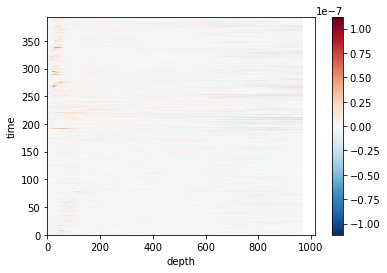

In [58]:
a_mean.plot()

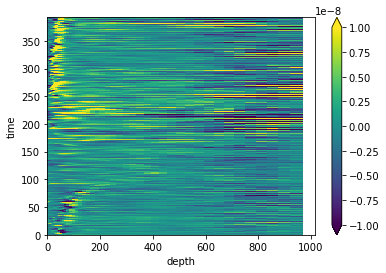

In [64]:
a_mean.plot(vmin=-1e-8, vmax=1e-8)

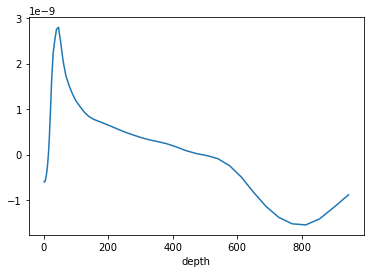

In [74]:
a_mean.mean('time').plot()

# 2. Parameter

## 2.1 Rossby number

In [9]:
zeta = (gridx.diff(ds.dyC*ds['V'].isel(depth=1),'X') - gridx.diff(ds.dxC * ds['U'].isel(depth=1),'Y'))/ds.rAz
zeta

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415)>
dask.array<shape=(201, 177, 9415), dtype=float32, chunksize=(1, 1, 9415)>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    rAz      (lat_g, lon_g) float32 ...

In [10]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.000107, 0.000107, 0.000107, ..., 0.000107, 0.000107, 0.000107],
       [0.000107, 0.000107, 0.000107, ..., 0.000107, 0.000107, 0.000107],
       [0.000108, 0.000108, 0.000108, ..., 0.000108, 0.000108, 0.000108],
       ...,
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112]],
      dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 47.39811 47.39811 ...
    rAz      (lat_g, lon_g) float32 ...

In [11]:
zeta_f = (zeta/f).load()

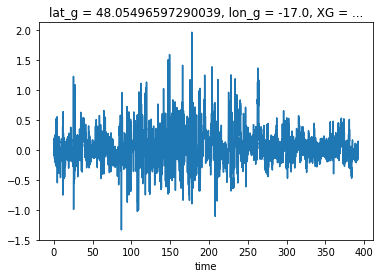

In [12]:
zeta_f.isel(lat_g=50, lon_g=50).plot()

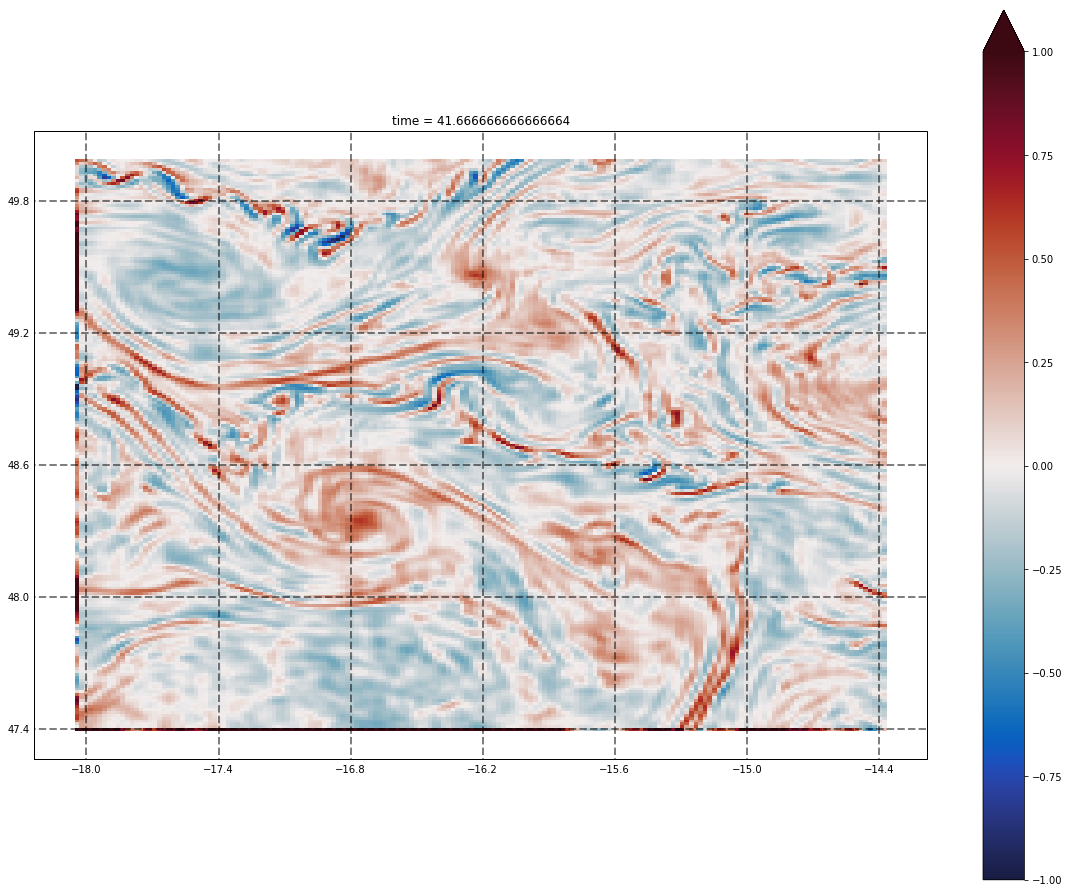

In [13]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
zeta_f.isel(time=1000).plot.pcolormesh(ax=ax, x='lon_g', y='lat_g', transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

## 2.2 KE

In [41]:
KE = (gridx.interp(ds['U'].isel(depth=1)**2,'X') + gridx.interp(ds['V'].isel(depth=1)**2,'Y'))/2 # KE
KE

<xarray.DataArray (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [42]:
KE = KE.load()

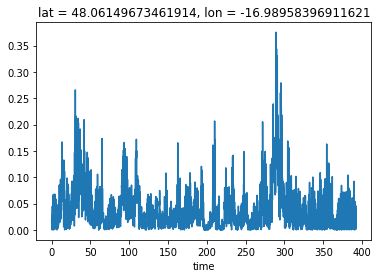

In [16]:
KE.isel(lat=50, lon=50).plot()

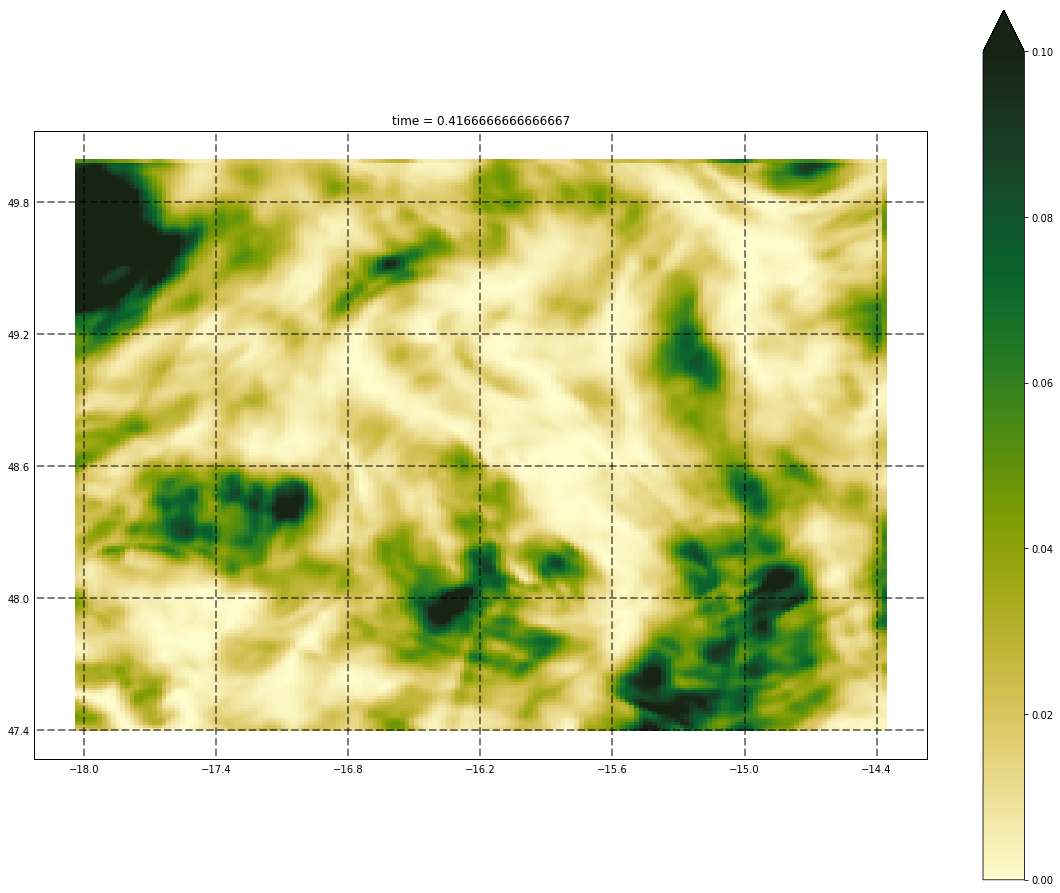

In [17]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE.isel(time=10).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=0, vmax=0.1, cmap = cm.speed)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

## 2.3 Horizontal strain

In [11]:
strain = (gridx.diff(ds['U'].isel(depth=1) * ds.dyG, 'X') - gridx.diff(ds['V'].isel(depth=1) * ds.dxG, 'Y')) / ds.rA
strain

<xarray.DataArray (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [13]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f_ij

<xarray.DataArray (lat: 201, lon: 177)>
array([[0.000107, 0.000107, 0.000107, ..., 0.000107, 0.000107, 0.000107],
       [0.000108, 0.000108, 0.000108, ..., 0.000108, 0.000108, 0.000108],
       [0.000108, 0.000108, 0.000108, ..., 0.000108, 0.000108, 0.000108],
       ...,
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.00011 , 0.00011 , 0.00011 , ..., 0.00011 , 0.00011 , 0.00011 ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [14]:
strain_f = (strain/f_ij).load()

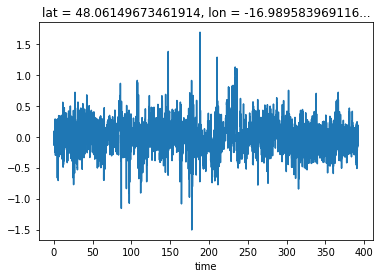

In [16]:
strain_f.isel(lat=50, lon=50).plot()

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


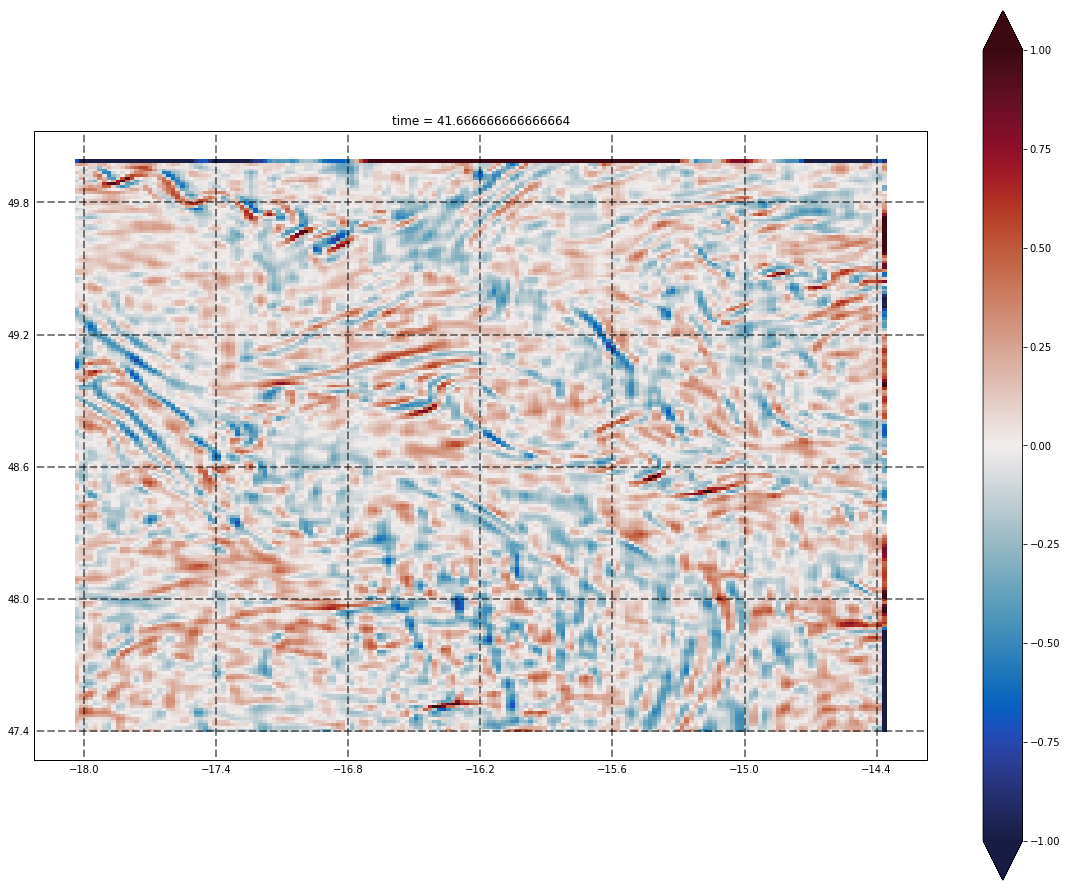

In [17]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
strain_f.isel(time=1000).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

## 2.4 lateral gradient

In [14]:
dT_dx = gridx.diff(ds['Theta'].isel(depth=1),'X')/ds.dxC     # dT/dx
dT_dx_ij = gridx.interp(dT_dx,'X')
#print(dT_dx_ij)

dT_dy = gridx.diff(ds['Theta'].isel(depth=1),'Y')/ds.dyC     # dT/dy
dT_dy_ij = gridx.interp(dT_dy,'Y')
#print(dT_dy_ij)

lateral_T_gradient = np.sqrt(dT_dx_ij*dT_dx_ij + dT_dy_ij*dT_dy_ij)
print(lateral_T_gradient)

<xarray.DataArray (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 1, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


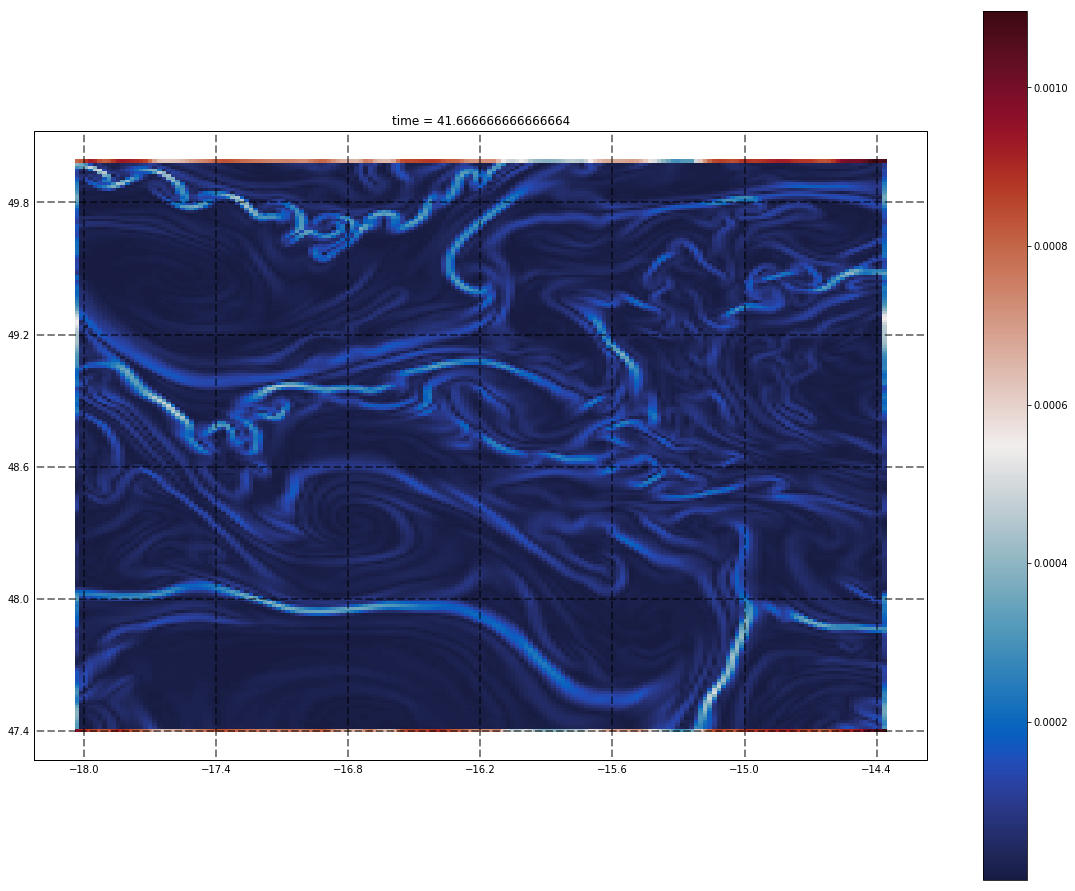

In [15]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
lateral_T_gradient.isel(time=1000).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [ ]:
lateral_T_gradient.isel(lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [76]:
cluster.scheduler.close()

<Future finished result=None>